In [1]:
import warnings

warnings.filterwarnings("ignore")

import itertools
import json
import math
import os
import re
import sys
from collections import Counter
from copy import deepcopy
from functools import reduce
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from networkx.algorithms.shortest_paths.weighted import dijkstra_path_length
from rich import print
from tqdm import tqdm

In [2]:
def plot_mtx(mtx):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(mtx, cmap=plt.cm.Blues)
    for i in range(mtx.shape[0]):
        for j in range(mtx.shape[1]):
            c = mtx[i, j]
    plt.plot()

In [3]:
def read_file_to_str_li(fp, print_exp=True):
    with open(fp, "r") as f:
        lines = f.read().split("\n")
    if print_exp:
        print(f"Read from {fp}:")
        print(f"First line: {lines[0]} | Last line: {lines[-1]}")
        print("-" * 6)

    return lines


# define the function blocks
def convert_to_int(input_str):
    if input_str == "" or input_str == " ":
        return None
    return int(input_str)


def convert_to_str(input_str):
    return str(input_str)


# map the inputs to the function blocks
converts = {
    "i": convert_to_int,
    "s": convert_to_str,
}


def convert_str_li_to_other_li(
    str_li, pattern="i", per_letter=False, sep=" ", start_row=0, end_row=None
):
    """Convert a list of string to a list of other types

    pattern: a list of types for one item.
        'i' for int, 's' for string
        'si' means: convert the 1st item to string, the rest to integer
        If separated items are more than pattern items,
        use the last one from the parttern.
    if per_letter=True, ignore sep and separate item per letter
    """
    target_str_li = str_li[start_row:end_row]
    # find max item num
    max_item_num = 1
    if per_letter:
        max_item_num = max([len(s) for s in target_str_li])
    else:
        max_item_num = max([len(s.split(sep)) for s in target_str_li])

    # extend the pattern to the max itme num
    pattern = (
        pattern + f"{pattern[-1]}" * (max_item_num - len(pattern))
        if max_item_num > len(pattern)
        else pattern
    )

    # convert
    if per_letter:
        return [
            [converts[pattern[idx]](item) for idx, item in enumerate(s)]
            for s in target_str_li
        ]
    else:
        if sep == " ":
            return [
                [converts[pattern[idx]](item) for idx, item in enumerate(s.split())]
                for s in target_str_li
            ]
        else:
            return [
                [converts[pattern[idx]](item) for idx, item in enumerate(s.split(sep))]
                for s in target_str_li
            ]

In [4]:
fp = "input.txt"
lines = read_file_to_str_li(fp)

print("Convert to:")

# head = convert_str_li_to_other_li(
#     lines, pattern="s", per_letter=True, sep=",", start_row=0, end_row=1
# )

# print(f"Head:\n{head}")
# print(f"First line: {head[0]}")
# print(f"Last line: {head[-1]}")

data = convert_str_li_to_other_li(
    lines, pattern="s", per_letter=False, sep=" ", start_row=None, end_row=None
)


print(f"First line: {data[0]}")
print(f"Last line: {data[-1]}")
print("-" * 6)

Read from input.txt:

First line: Valve NV has flow rate=5; tunnels lead to valves ZV, CG, YB, HX, OY | Last line: 
Valve QV has flow rate=0; tunnels lead to valves JM, KZ

------

Convert to:

First line: ['Valve', 'NV', 'has', 'flow', 'rate=5;', 'tunnels', 'lead', 'to', 'valves', 
'ZV,', 'CG,', 'YB,', 'HX,', 'OY']

Last line: ['Valve', 'QV', 'has', 'flow', 'rate=0;', 'tunnels', 'lead', 'to', 'valves', 
'JM,', 'KZ']

------

{
    'NV': 5,
    'NU': 6,
    'DG': 9,
    'PH': 7,
    'KZ': 12,
    'EJ': 20,
    'RG': 4,
    'DO': 14,
    'FX': 23,
    'YA': 17,
    'NO': 8,
    'XK': 24,
    'PS': 18,
    'JM': 19,
    'UX': 13
}

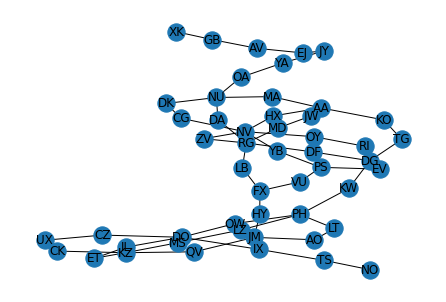

In [5]:
G = nx.Graph()  # or Graph, MultiGraph, MultiDiGraph, etc
v_rate = dict()
zero_v = []
for line in data:
    s_valve = line[1]
    rate = int(line[4].split("=")[1][:-1])
    if rate > 0:
        v_rate[s_valve] = rate
    else:
        zero_v.append(s_valve)
    for idx in range(9, len(line)):
        d_valve = line[idx].split(",")[0]
        G.add_edge(s_valve, d_valve)

print(v_rate)
nx.draw(G, with_labels=True)
plt.show()

In [6]:
dist_dict = {}
for node1 in G.nodes():
    for node2 in G.nodes():
        if node1 != node2:
            dist_dict[(node1, node2)] = dijkstra_path_length(G, node1, node2)

In [7]:
class State:
    def __init__(self, init_time, closed_valve, start_pos="AA", cum_layout=0):
        self.remain_time = init_time
        self.cum_layout = cum_layout
        self.pos = start_pos
        self.closed_valve = closed_valve
        self.closed_valve_rate = []
        self.distance_to_next_closed_valve = []

    def update_state(self):
        self.closed_valve_rate = [v_rate[v] for v in self.closed_valve]
        self.distance_to_next_closed_valve = [
            dist_dict[(self.pos, v)] for v in self.closed_valve
        ]

    def check_end(self, current_max_layout):
        if len(self.closed_valve) == 0:  # all opened
            return True

        still_r_time = self.remain_time - min(self.distance_to_next_closed_valve) - 1
        c_v_rate_li = self.closed_valve_rate.copy()
        c_v_rate_li.sort(reverse=True)
        added_layout = 0
        for c_v_rate in c_v_rate_li:
            added_layout += still_r_time * c_v_rate
            still_r_time -= 2
            if still_r_time <= 0:
                break

        if current_max_layout > (self.cum_layout + added_layout):
            return True
        return False

    def open_next_valve(self, next_node, current_max_layout):
        self.remain_time = self.remain_time - dist_dict[(self.pos, next_node)] - 1
        self.pos = next_node
        self.cum_layout += self.remain_time * v_rate[next_node]
        if self.cum_layout > current_max_layout:
            current_max_layout = self.cum_layout
        self.closed_valve.remove(next_node)
        self.update_state()
        return current_max_layout

In [8]:
def go_further(state, current_max_layout):
    next_node_list = state.closed_valve
    for next_node in next_node_list:
        next_state = deepcopy(state)
        current_max_layout = next_state.open_next_valve(next_node, current_max_layout)
        if not next_state.check_end(current_max_layout):
            current_max_layout = go_further(next_state, current_max_layout)
    return current_max_layout


def get_max_layout(init_time, closed_valve):
    current_max_layout = 0
    init_state = State(init_time=init_time, closed_valve=closed_valve)
    init_state.update_state()
    current_max_layout = go_further(init_state, current_max_layout)
    return current_max_layout

In [9]:
%%time
init_time = 30
print(f"Answer to Q1: {get_max_layout(init_time, list(v_rate.keys()))}")

Answer to Q1: 1923

Wall time: 634 ms


In [10]:
%%time
from joblib import Parallel, delayed

target_li = []
for num_target in range(1, len(v_rate) // 2 + 1):
    for target_1 in itertools.combinations(list(v_rate.keys()), num_target):
        target_2 = list(set(v_rate.keys()) - set(target_1))
        target_li.append((list(target_1), target_2))


def get_sum_max_layout(target_1, target_2, init_time):
    return get_max_layout(init_time, target_1) + get_max_layout(init_time, target_2)


init_time = 26
result = Parallel(n_jobs=-1)(
    delayed(get_sum_max_layout)(target_1, target_2, init_time)
    for (target_1, target_2) in tqdm(target_li)
)
print(f"Answer to Q2: {max(result)}")

100%|███████████████████████████████████████████████████████| 16383/16383 [04:36<00:00, 59.20it/s]


Answer to Q2: 2594

Wall time: 4min 37s
